### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [92]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
rng = np.random.default_rng()

In [93]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 888 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .02 # central bank lending rate
max_rate_mult = 10 # multiplier on cb_rate to calculate max rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 1.1 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .01 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits
max_loan_mult = 10 * max_balance # no bank should can take more than 10x its initial deposits in loans
ZERO_THRESHOLD = 0.01  # Amounts below this are considered zero
MINIMUM_LOAN = max_balance * 0.01    # Don't bother with loans smaller than this
more_verbose = False

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [94]:
# define utility functions

# a serious utility
def maybe_display(message):
    if more_verbose:
        display(message)  # Changed from display() to print()
    else:
        if "bailout" in str(message).lower():  # Always show bailout messages
            display(message)

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preference

    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of max_rate_mult * cb_rate
    quote = round(min(cb_rate + adjusted_premium, max_rate_mult * cb_rate), 4)

    # maybe_display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    # maybe_display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    # maybe_display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    # maybe_display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, lenders,
                         reserves, customers, banks, balances): # some severe accounting about to happen
    
    net_positions = []
    
    # Precompute total deposits per bank for convenience
    deposits_per_bank = [0]*N
    for c in range(len(customers)):
        deposits_per_bank[banks[c]] += balances[c]
    
    # For each bank, identify how much it has borrowed (loansIn, interestIn)
    # and how much it has lent to others (loansOut, interestOut).
    # Remember: loans[b] are amounts bank b *borrowed*. So "loansOut"
    # must be found by scanning other banks' arrays for occurrences of b in lenders[i].
    
    # 1) Build "loansIn" and "interestIn" easily from loans[b], rates[b].
    #    This is what b owes.
    loans_in = [0]*N      # principal borrowed
    interest_in = [0]*N   # interest b owes
    for b in range(N):
        for loan_amt, r in zip(loans[b], rates[b]):
            loans_in[b]    += loan_amt
            interest_in[b] += (loan_amt * r)
    
    # 2) Build "loansOut" and "interestOut" by scanning other banks that borrowed from b
    loans_out = [0]*N
    interest_out = [0]*N
    for borrower in range(N):
        for idx, lender_bank in enumerate(lenders[borrower]):
            if lender_bank is not None:    # skip Fed loans
                if lender_bank < N:        # basic check if it's a real bank
                    if lender_bank >= 0 and lender_bank < N:
                        # The loan principal is loans[borrower][idx]
                        # The interest rate is rates[borrower][idx]
                        # So bank "lender_bank" is owed that principal + interest
                        loans_out[lender_bank]    += loans[borrower][idx]
                        interest_out[lender_bank] += (loans[borrower][idx] * rates[borrower][idx])
    
    # 3) For each bank b, compute assets vs. liabilities
    for b in range(N):
        bank_deposits = deposits_per_bank[b]   # total retail deposits for b
        required_reserves = bank_deposits * reserve_reqmt
        
        # b's assets = its reserves + what it's owed (loansOut + interestOut)
        assets = reserves[b] + loans_out[b] + interest_out[b]
        
        # b's liabilities = retail deposits + what it owes (loansIn + interestIn)
        liabilities = bank_deposits + loans_in[b] + interest_in[b]
        
        if required_reserves > 0:
            net_pos = (assets - liabilities) / required_reserves
        else:
            net_pos = 0.0
        
        # Round to 4 decimals
        net_positions.append(round(net_pos, 4))
    
    return net_positions


# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = round(percentages[t] * balances[originators[t]], 2)
        if amount < MINIMUM_LOAN:
            continue # skip transactions that are too small to bother with
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    # Fed borrowers cannot offer quotes, so remove any possible lender with a loan from None
    possible_lenders = [x for x in possible_lenders if lenders[x] is not None]
    random.shuffle(possible_lenders)
    random.shuffle(deficit_banks)  # otherwise, the first bank in the list will always settle first

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction)

    for i in deficit_banks:
        # just zero out sub-threshold reserves. weʻll have a leap second some day...
        if abs(reserves[i]) < ZERO_THRESHOLD:
            reserves[i] = 0
            continue

        # just zero out sub-MINIMUM_LOAN reserves. weʻll have a leap second some day...    
        if abs(reserves[i]) < MINIMUM_LOAN:
            reserves[i] = 0
            continue
        
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:            
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0]
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    reserves[lender] = round(reserves[lender], 2)
                    maybe_display(f"Writing full loan to borrower {i} from lender {lender} for amount {abs(reserves[i])} at rate {quoted_rate}")
                    loans[i].append(round(abs(reserves[i]), 2))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                    maybe_display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")
                elif reserves[lender] > 0:
                    maybe_display(f"Writing partial loan to borrower {i} from lender {lender} for amount {reserves[lender]} at rate {quoted_rate}")
                    loans[i].append(round(reserves[lender], 2))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[i] = round(reserves[i], 2)
                    reserves[lender] = 0
                    maybe_display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")                    
                    j += 1
                else:
                    maybe_display(f"Lender {lender} has no reserves to lend")
                    j += 1
        
    for i_bad in deficit_banks:
        # if we still have a deficit, we need to call the Fed
        # Fed will repay all the outstanding loans and then set the bankʻs reserves back to the recap amount
        # This will go onto the books as one loan from the fed, at the backstop rate
        # And then we will set the risk appetite to 0.01

        if reserves[i_bad] < 0:  # Removed bailouts_are_allowed check since we always need to resolve negatives
            display(f"Borrower {i_bad} needs a bailout")
            display(f"Borrower {i_bad} has {reserves[i_bad]} reserves")
            display(f"Borrower {i_bad} has {loans[i_bad]} loans")

            # First, repay all existing loans
            for idx, loan in enumerate(loans[i_bad]):
                lender = lenders[i_bad][idx]
                rate = rates[i_bad][idx]
                if lender is not None:  # if it's not already a Fed loan
                    reserves[lender] += loan * (1 + rate)  # Repay with interest

            # now reset the bank
            recap_amount = round(max_balance * bailout_deficit_multiplier, 0)
            display(f"Borrower {i_bad} needs a bailout of {recap_amount}")
            loans[i_bad] = [recap_amount] # REPLACE the loans, donʻt append. Fed ensures all outstanding debt is repaid.
            rates[i_bad] = [backstop_rate]
            lenders[i_bad] = [None]
            reserves[i_bad] = recap_amount
            risk_appetites[i_bad] = 0.01
            bailouts.append((i_bad, recap_amount))
            
            display(f"Fed bailout complete. Borrower {i_bad} now has {loans[i_bad]} loans and {reserves[i_bad]} reserves.")

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [95]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, lenders, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):

    if s % 100 == 0:
        display(f"Step {s}")
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, lenders, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    financial_system_step['fed_recapitalization'] = [bailouts]


    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

'Step 100'

'Step 200'

'Step 300'

'Step 400'

'Borrower 8 needs a bailout'

'Borrower 8 has -68608.0 reserves'

'Borrower 8 has [4.447123091539153e+18] loans'

'Borrower 8 needs a bailout of 110.0'

'Fed bailout complete. Borrower 8 now has [110.0] loans and 110.0 reserves.'

'Step 500'

'Step 600'

'Borrower 0 needs a bailout'

'Borrower 0 has -7.378697629483821e+19 reserves'

'Borrower 0 has [2.8796200708923716e+35] loans'

'Borrower 0 needs a bailout of 110.0'

'Fed bailout complete. Borrower 0 now has [110.0] loans and 110.0 reserves.'

'Step 700'

'Step 800'

'Borrower 6 needs a bailout'

'Borrower 6 has -3.32306998946229e+35 reserves'

'Borrower 6 has [1.2728969261985037e+51] loans'

'Borrower 6 needs a bailout of 110.0'

'Fed bailout complete. Borrower 6 now has [110.0] loans and 110.0 reserves.'

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) interest rates
2) reserve account balances for each bank over time.

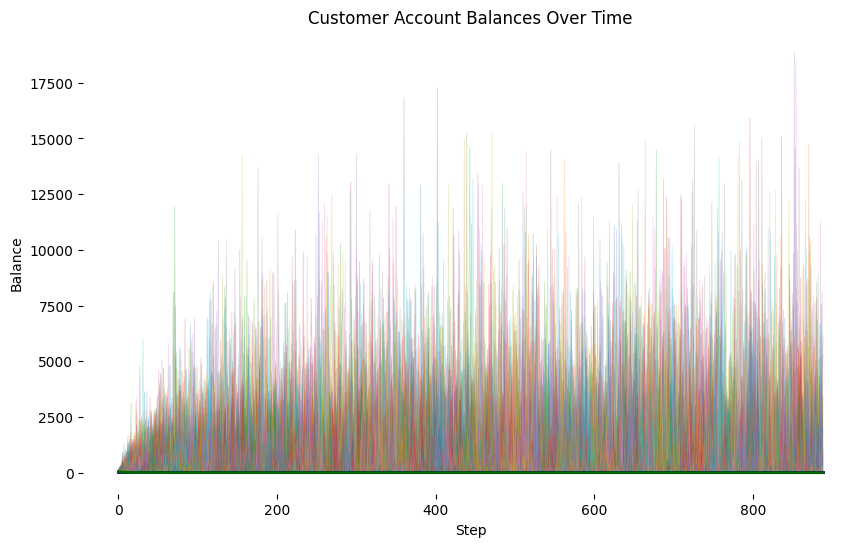

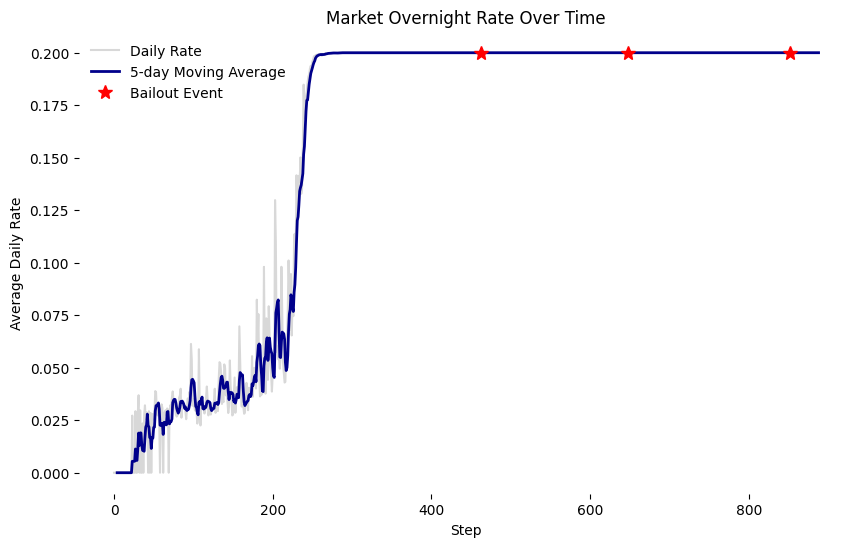

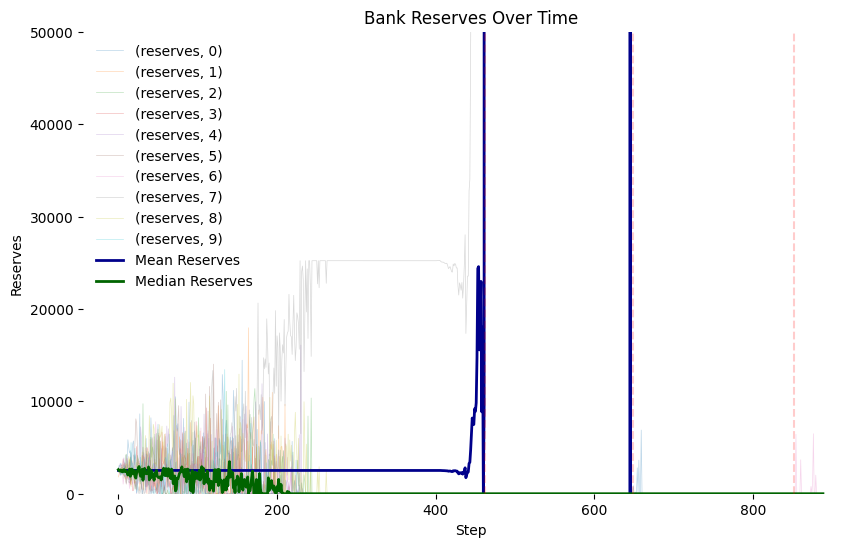

In [96]:
# For the customer balances plot
plt.figure(figsize=(10, 6))
customer_wide = pd.pivot_table(customer_history, index=['step'], values=['balance'], columns=['id'])

# Plot individual customer lines with low opacity
customer_wide.plot(linewidth=0.5, alpha=0.3, legend=None, ax=plt.gca())

# Calculate mean of non-zero balances and median
non_zero_mean = customer_wide.replace(0, np.nan).mean(axis=1)
median = customer_wide.median(axis=1)

# Add mean and median lines
plt.plot(customer_wide.index, non_zero_mean, 
         color='darkblue', linewidth=2, label='Mean Non-Zero Balance')
plt.plot(customer_wide.index, median, 
         color='darkgreen', linewidth=2, label='Median Balance')

plt.title('Customer Account Balances Over Time')
plt.xlabel('Step')
plt.ylabel('Balance')
sns.despine(left=True, bottom=True)
plt.show()


# For the market rate plot
plt.figure(figsize=(10, 6))
# Plot individual rates
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'], 
         alpha=0.3, color='gray', label='Daily Rate')
# Add rolling mean
rolling_mean = financial_system_history['avg_daily_rate'].rolling(window=5).mean()
plt.plot(financial_system_history['step'], rolling_mean, 
         color='darkblue', linewidth=2, label='5-day Moving Average')

# Add stars for bailout events
bailout_steps = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['step']
bailout_rates = financial_system_history[financial_system_history['fed_recapitalization'].apply(lambda x: x is not None and len(x) > 0)]['avg_daily_rate']
plt.plot(bailout_steps, bailout_rates, '*', color='red', markersize=10, label='Bailout Event')

plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

# For the reserves plot
plt.figure(figsize=(10, 6))
bank_wide = pd.pivot_table(bank_history, index=['step'], values=['reserves'], columns=['id'])

# Plot individual bank lines with low opacity
bank_wide.plot(linewidth=0.5, alpha=0.3, legend=None, ax=plt.gca())

# Add mean and median lines
plt.plot(bank_wide.index, bank_wide.mean(axis=1), 
         color='darkblue', linewidth=2, label='Mean Reserves')
plt.plot(bank_wide.index, bank_wide.median(axis=1), 
         color='darkgreen', linewidth=2, label='Median Reserves')

# Max the bank-wide plot y axis at 500 times the initial max value
plt.ylim(0, 500 * max_balance)

# Add stars for bailout events
for step in bailout_steps:
    plt.axvline(x=step, color='red', alpha=0.2, linestyle='--')
    plt.plot(step, bank_wide.loc[step].max(), '*', color='red', markersize=10)

plt.title('Bank Reserves Over Time')
plt.xlabel('Step')
plt.ylabel('Reserves')
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.show()

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

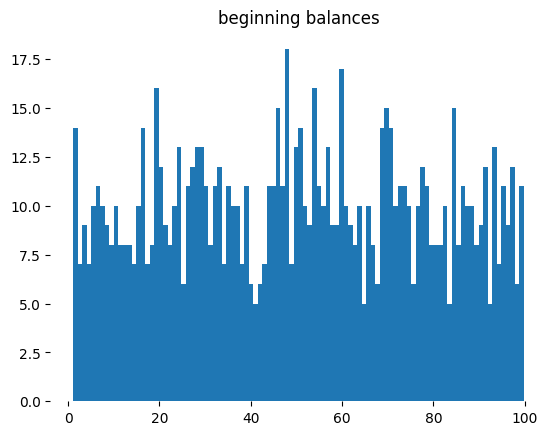

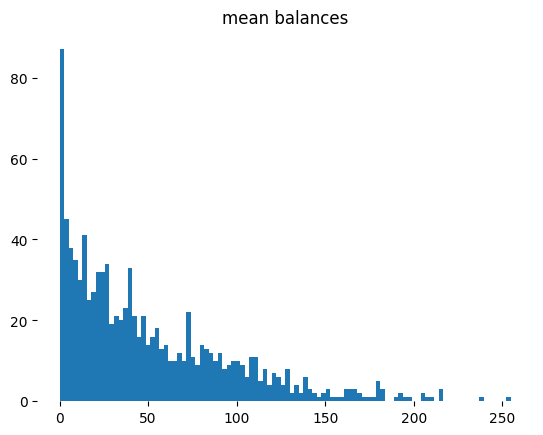

In [97]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

In [98]:
display(financial_system_history)


,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000e+00,0.0,0.000000,None
1,1,-9.987800e-01,0.0,0.229754,[]
2,2,-1.001140e+00,0.0,0.229754,[]
3,3,-1.003030e+00,0.0,0.229754,[]
4,4,-1.000510e+00,0.0,0.229754,[]
...,...,...,...,...,...
884,884,4.497815e+50,0.2,0.170322,[]
885,885,2.807988e+50,0.2,0.170322,[]
886,886,7.070380e+48,0.2,0.170322,[]
887,887,4.113840e+50,0.2,0.170322,[]


This final plot shows, for each bank, mean reserve and loan values.

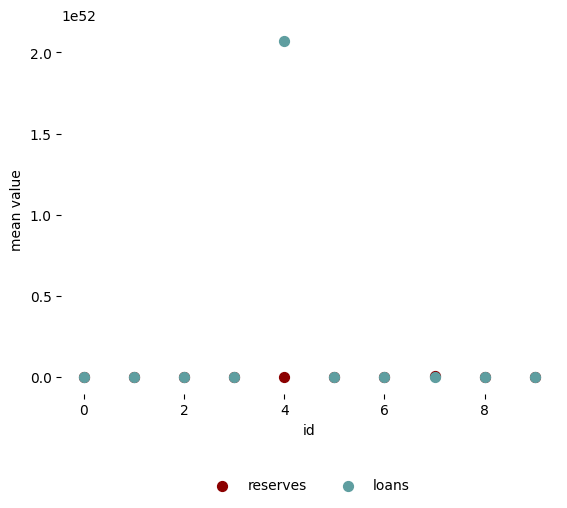

In [99]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [100]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()

Output()